# VAE Evaluation and Analysis

**Imports**

In [78]:
# Basic imports
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import math

from matplotlib import pyplot as plt

from torch.optim import Adam

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
from torchvision.utils import save_image, make_grid

from astropy.io import fits
from astropy.table import Table

**Model import**

In [79]:
# Hyperparameters
dataset_path = '~/datasets'
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

# Data parameters
input_rows = 20000   # Number of spectra to input
batch_size = 100    # Tested 100
validation_split = .2   # Fraction of dataset to reserve for test
random_seed = 42
np.random.seed(random_seed)
shuffle_toggle = False  # Redundant due to random reduced idx already implemented

# Model Dimensions
x_dim  = 7514
# Originally 400, 200
hidden_dim = 400
latent_dim = 28

# Learning rate
# Default 0.001
lr = 0.001

# VAE Beta
beta = 1

# Num epochs
epochs = 10000

In [80]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(Encoder, self).__init__()

    # FC Linear version
    self.FC_input = nn.Linear(input_dim, 3757)
    # Try batch normalization
    # nn.BatchNorm1d(hidden_dim)
    self.FC_input2 = nn.Linear(3757, 1878)
    self.FC_input3 = nn.Linear(1878, 939)
    self.FC_input4 = nn.Linear(939, 469)
    self.FC_input5 = nn.Linear(469, 234)
    self.FC_input6 = nn.Linear(234, 117)
    self.FC_input7 = nn.Linear(117, 58)
    # self.FC_input8 = nn.Linear(58, 29)

    # Increase number of layers!!

    # Mean and log variance
    self.FC_mean  = nn.Linear(58, latent_dim)
    self.FC_var   = nn.Linear(58, latent_dim)
    
    self.LeakyReLU = nn.LeakyReLU()
    self.gelu = torch.nn.GELU()
    
    self.training = True
      
  def forward(self, x):
    h_ = self.gelu(self.FC_input(x))
    h_ = self.gelu(self.FC_input2(h_))
    h_ = self.gelu(self.FC_input3(h_))
    h_ = self.gelu(self.FC_input4(h_))
    h_ = self.gelu(self.FC_input5(h_))
    h_ = self.gelu(self.FC_input6(h_))
    h_ = self.gelu(self.FC_input7(h_))
    # h_ = self.LeakyReLU(self.FC_input8(h_))

    mean = self.FC_mean(h_)
    log_var = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                  #             (i.e., parameters of simple tractable normal distribution "q"
    
    return mean, log_var

In [81]:
class Decoder(nn.Module):
  def __init__(self, latent_dim, hidden_dim, output_dim):
    super(Decoder, self).__init__()

    # FC Linear version
    # self.FC_hidden = nn.Linear(latent_dim, 29)
    self.FC_hidden2 = nn.Linear(latent_dim, 58)
    self.FC_hidden3 = nn.Linear(58, 117)
    self.FC_hidden4 = nn.Linear(117, 234)
    self.FC_hidden5 = nn.Linear(234, 469)
    self.FC_hidden6 = nn.Linear(469, 939)
    self.FC_hidden7 = nn.Linear(939, 1878)
    self.FC_hidden8 = nn.Linear(1878, 3757)
    self.FC_output = nn.Linear(3757, output_dim)
    
    self.LeakyReLU = nn.LeakyReLU()
    self.gelu = torch.nn.GELU()

  def forward(self, x):
    # h = self.LeakyReLU(self.FC_hidden(x))
    h = self.gelu(self.FC_hidden2(x))
    h = self.gelu(self.FC_hidden3(h))
    h = self.gelu(self.FC_hidden4(h))
    h = self.gelu(self.FC_hidden5(h))
    h = self.gelu(self.FC_hidden6(h))
    h = self.gelu(self.FC_hidden7(h))
    h = self.gelu(self.FC_hidden8(h))
  
    # originally torch.sigmoid, but output range incorrect
    # Replace with smooth function - look into this!!
    # Softplus, gelu 

    #activation = torch.nn.Softplus()
    activation = torch.nn.GELU()
    x_hat = activation(self.FC_output(h))
    #x_hat = torch.nn.GELU(self.FC_output(h))
    #print(x_hat)
    return x_hat

In [82]:
class Model(nn.Module):
  def __init__(self, Encoder, Decoder):
    super(Model, self).__init__()
    self.Encoder = Encoder
    self.Decoder = Decoder

  def reparameterization(self, mean, var):
    epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
    z = mean + var*epsilon                          # reparameterization trick
    return z
              
  def forward(self, x):
    # Generate mean, log var
    mean, log_var = self.Encoder(x)

    z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
    x_hat = self.Decoder(z)
    
    # Modified in evaluation file to return latent vector z
    return x_hat, mean, log_var, z

In [83]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [84]:
model.load_state_dict(torch.load('vae_5000.pt'))

<All keys matched successfully>

In [85]:
model.eval()

Model(
  (Encoder): Encoder(
    (FC_input): Linear(in_features=7514, out_features=3757, bias=True)
    (FC_input2): Linear(in_features=3757, out_features=1878, bias=True)
    (FC_input3): Linear(in_features=1878, out_features=939, bias=True)
    (FC_input4): Linear(in_features=939, out_features=469, bias=True)
    (FC_input5): Linear(in_features=469, out_features=234, bias=True)
    (FC_input6): Linear(in_features=234, out_features=117, bias=True)
    (FC_input7): Linear(in_features=117, out_features=58, bias=True)
    (FC_mean): Linear(in_features=58, out_features=28, bias=True)
    (FC_var): Linear(in_features=58, out_features=28, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.01)
    (gelu): GELU()
  )
  (Decoder): Decoder(
    (FC_hidden2): Linear(in_features=28, out_features=58, bias=True)
    (FC_hidden3): Linear(in_features=58, out_features=117, bias=True)
    (FC_hidden4): Linear(in_features=117, out_features=234, bias=True)
    (FC_hidden5): Linear(in_features=234, ou

**Data Load**

In [86]:
print("\n ********************** Opening FITS files from drive **********************")

star_hdus = fits.open('allStar-r12-l33.fits')
astroNN_hdus = fits.open('apogee_astroNN-DR16-v1.fits')
star_spec = fits.open('contspec_dr16_final.fits')

star = star_hdus[1].data
star_astroNN = astroNN_hdus[1].data
star_spectra = star_spec[0].data

star_hdus.close()
astroNN_hdus.close()
star_spec.close()

print("Number of spectra: ", len(star))
print("Data points per spectra: ", len(star_spectra[1]))

# starInfoDebug()


 ********************** Opening FITS files from drive **********************
Number of spectra:  473307
Data points per spectra:  7514


In [87]:
star_mask = fits.open('contspec_dr16_mask.fits')
star_err = fits.open('contspec_dr16_err.fits')

star_mask_data = star_mask[0].data
star_err_data = star_err[0].data

star_mask.close()
star_err.close()

print("Number of masks: ", len(star_mask_data))
print("Data points per maskk: ", len(star_mask_data[1]))

print("Number of errors: ", len(star_err_data))
print("Data points per error: ", len(star_err_data[1]))

Number of masks:  473307
Data points per maskk:  7514
Number of errors:  473307
Data points per error:  7514


In [88]:
# Further Star Analysis

from astropy.table import Table
dat = Table.read('allStar-r12-l33.fits', format='fits')
names = [name for name in dat.colnames if len(dat[name].shape) <= 1]
df = dat[names].to_pandas()
df.head()

APSTAR_ID  \
0          b'apogee.apo1m.s.stars.calibration.VESTA'   
1  b'apogee.apo25m.s.stars.120+12.2M00000002+7417...   
2  b'apogee.apo25m.s.stars.060-75.2M00000019-1924...   
3  b'apogee.apo25m.s.stars.116-04.2M00000032+5737...   
4  b'apogee.apo25m.s.stars.N7789.2M00000032+5737103'   

                                  TARGET_ID  \
0              b'apo1m.1.calibration.VESTA'   
1  b'apo25m.5046.120+12.2M00000002+7417074'   
2  b'apo25m.5071.060-75.2M00000019-1924498'   
3  b'apo25m.4424.116-04.2M00000032+5737103'   
4   b'apo25m.4264.N7789.2M00000032+5737103'   

                                           ASPCAP_ID  \
0        b'apogee.apo1m.s.r12-l33.calibration.VESTA'   
1  b'apogee.apo25m.s.r12-l33.120+12.2M00000002+74...   
2  b'apogee.apo25m.s.r12-l33.060-75.2M00000019-19...   
3  b'apogee.apo25m.s.r12-l33.116-04.2M00000032+57...   
4  b'apogee.apo25m.s.r12-l33.N7789.2M00000032+573...   

                                    FILE              APOGEE_ID  TELESCOPE  \
0               b'apStar-r12-VESTA.fits'               b'VESTA'   b'apo1m'   
1  b'apStar-r12-2M00000002+7417074.fits'  b'2M00000002+7417074'  b'apo25m'   
2  b'apStar-r12-2M00000019-1924498.fits'  b'2M00000019-1924498'  b'apo25m'   
3  b'apStar-r12-2M00000032+5737103.fits'  b'2M00000032+5737103'  b'apo25m'   
4  b'apStar-r12-2M00000032+5737103.fits'  b'2M00000032+5737103'  b'apo25m'   

   LOCATION_ID           FIELD            J        J_ERR  ...  \
0            1  b'calibration' -9999.990234 -9999.990234  ...   
1         5046       b'120+12'     8.597000     0.039000  ...   
2         5071       b'060-75'    11.074000     0.022000  ...   
3         4424       b'116-04'    10.905000     0.023000  ...   
4         4264        b'N7789'    10.905000     0.023000  ...   

   GAIA_PHOT_G_MEAN_MAG  GAIA_PHOT_BP_MEAN_MAG  GAIA_PHOT_RP_MEAN_MAG  \
0          -9999.000000           -9999.000000           -9999.000000   
1             11.709962              13.291449              10.511990   
2             12.187422              12.534893              11.669607   
3             12.230203              12.671972              11.631516   
4             12.230203              12.671972              11.631516   

   GAIA_RADIAL_VELOCITY  GAIA_RADIAL_VELOCITY_ERROR   GAIA_R_EST    GAIA_R_LO  \
0          -9999.000000                -9999.000000 -9999.000000 -9999.000000   
1            -51.924661                    0.365646  3285.226548  2959.076000   
2             17.880444                    2.120882   191.348325   156.570781   
3            -19.196012                    1.356420   801.567552   780.757419   
4            -19.196012                    1.356420   801.567552   780.757419   

     GAIA_R_HI    TEFF_SPEC  LOGG_SPEC  
0 -9999.000000  5770.700195    4.49400  
1  3687.594547  3628.600098    0.88758  
2   245.761634  5527.700195    4.23810  
3   823.495963  6449.200195    4.01460  
4   823.495963  6411.600098    3.97610  

[5 rows x 204 columns]


STAR_WARN,COLORTE_WARN
STAR_WARN,COLORTE_WARN,STAR_BAD,COLORTE_BAD
STAR_WARN,ROTATION_WARN,STAR_BAD,ROTATION_BAD
STAR_WARN,ROTATION_WARN
STAR_WARN,COLORTE_WARN,ROTATION_WARN,STAR_BAD
STAR_WARN,COLORTE_WARN,ROTATION_WARN,STAR_BAD,COLORTE_BAD,ROTATION_BAD
STAR_WARN,ROTATION_WARN,STAR_BAD
STAR_WARN,COLORTE_WARN,ROTATION_WARN,STAR_BAD,ROTATION_BAD
STAR_BAD
STAR_WARN,COLORTE_WARN,ROTATION_WARN,STAR_BAD,COLORTE_BAD
STAR_WARN,COLORTE_WARN,STAR_BAD
STAR_WARN,CHI2_WARN,COLORTE_WARN,ROTATION_WARN,STAR_BAD,COLORTE_BAD,ROTATION_BAD
STAR_WARN,COLORTE_WARN,ROTATION_WARN
STAR_WARN,CHI2_WARN,ROTATION_WARN,STAR_BAD,CHI2_BAD,ROTATION_BAD
STAR_WARN,CHI2_WARN,STAR_BAD,CHI2_BAD
STAR_WARN,CHI2_WARN
STAR_WARN,CHI2_WARN,ROTATION_WARN,STAR_BAD,ROTATION_BAD
STAR_WARN,CHI2_WARN,COLORTE_WARN,ROTATION_WARN,STAR_BAD,CHI2_BAD,COLORTE_BAD,ROTATION_BAD
STAR_WARN,CHI2_WARN,ROTATION_WARN,STAR_BAD,CHI2_BAD


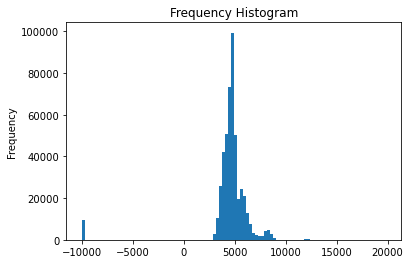

In [89]:
# Isolate critical columns
star_df = df[['APSTAR_ID', 'TEFF_SPEC', 'LOGG_SPEC', 'SNR', 'ASPCAPFLAGS', 'STARFLAGS']]

star_snr = star_df[["TEFF_SPEC"]]
plt.hist(star_snr, bins=100)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

#We only include stars with no bad star flags set, SNR > 200, 4000 < teff < 5500, and logg < 3.5.
star_df_best = star_df.loc[(star_df['TEFF_SPEC'] < 5500) & (star_df['TEFF_SPEC'] > 4000) & (star_df['LOGG_SPEC'] < 3.5) & (star_df['SNR'] > 200)]

flagList = star_df_best['ASPCAPFLAGS'].unique()
for flag in flagList:
    print(flag.decode())

In [90]:
# Decode byte flags into strings
star_df_best['ASPCAPFLAGS'] = star_df_best['ASPCAPFLAGS'].str.decode("utf-8")

# Strip out stars with STAR_BAD flag
star_df_best = star_df_best.loc[~(star_df_best['ASPCAPFLAGS'].str.contains("STAR_BAD"))]
star_df_best

<ipython-input-90-78c17d3d77b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star_df_best['ASPCAPFLAGS'] = star_df_best['ASPCAPFLAGS'].str.decode("utf-8")


APSTAR_ID    TEFF_SPEC  \
18      b'apogee.apo25m.s.stars.120+08.2M00000866+7122...  4607.000000   
23      b'apogee.apo25m.s.stars.116+00.2M00001199+6114...  4611.000000   
28      b'apogee.apo25m.s.stars.N7789.2M00001328+5725563'  4447.200195   
34      b'apogee.apo25m.s.stars.N7789.2M00001653+5540107'  4040.199951   
37      b'apogee.apo25m.s.stars.116+00.2M00001717+6147...  4677.000000   
...                                                   ...          ...   
473289  b'apogee.apo25m.s.stars.120+12.2M23595481+7509...  4742.500000   
473290  b'apogee.apo25m.s.stars.N7789.2M23595490+5704387'  5017.799805   
473298  b'apogee.apo25m.s.stars.116+00.2M23595606+6251...  4198.600098   
473301  b'apogee.apo25m.s.stars.120+18.2M23595676+7918...  4171.299805   
473305  b'apogee.apo25m.s.stars.116-04.2M23595886+5726...  4806.399902   

        LOGG_SPEC         SNR ASPCAPFLAGS                   STARFLAGS  
18         2.7701  454.351990                                     b''  
23         2.6715  343.740997                                     b''  
28         2.4789  232.462997                                     b''  
34         1.7878  235.604004                                     b''  
37         2.5777  205.179001                          b'PERSIST_LOW'  
...           ...         ...         ...                         ...  
473289     2.8883  467.380005                                     b''  
473290     3.2260  606.460999                                     b''  
473298     2.0426  314.253998                                     b''  
473301     1.9010  443.684998                                     b''  
473305     2.7825  202.197998              b'PERSIST_MED,PERSIST_LOW'  

[73779 rows x 6 columns]

In [91]:
# Update the star_spectra dataframe with only 'good' indices
star_spectra = star_spectra[star_df_best.index]

# Update masks, errors as well
star_err_data = star_err_data[star_df_best.index]
star_mask_data = star_mask_data[star_df_best.index]


len(star_spectra)

73779

In [92]:
# https://visualstudiomagazine.com/articles/2020/09/10/pytorch-dataloader.aspx

class spectraDataset(torch.utils.data.Dataset):

  # Num rows = max number of spectra to load
  def __init__(self, src, num_rows=None):
    if num_rows == None:
      spectra = src.astype(np.float32)
    else:
      spectra = src.astype(np.float32)[0:num_rows]

    # y_tmp = np.loadtxt(src_file, max_rows=num_rows,
    #   usecols=7, delimiter="\t", skiprows=0,
    #   dtype=np.long)

    self.x_data = torch.tensor(spectra, dtype=torch.float32).to(DEVICE)

    # self.y_data = T.tensor(y_tmp,
    #   dtype=T.long).to(DEVICE)

  def __len__(self):
    return len(self.x_data)  # required

  def __getitem__(self, idx):
    # if T.is_tensor(idx):
    #   idx = idx.tolist()
    # preds = self.x_data[idx, 0:7]
    # pol = self.y_data[idx]
    # sample = \
    #   { 'predictors' : preds, 'political' : pol }

    sample = self.x_data[idx]
    return sample

In [93]:
# # Reduce the dataset down to a manageable size, based on input_rows hyperparameter
np.random.seed(random_seed)
random_reduced_idx = list(np.random.choice(len(star_spectra), input_rows, replace=False))

# # Grab only spectra with indices randomly selected from above
#reduced_star_spectra = np.take(star_spectra, random_reduced_idx, 0)
reduced_star_spectra = star_spectra[random_reduced_idx]
#print(pd.DataFrame(reduced_star_spectra))


# Normalize
for starRow in reduced_star_spectra:
    starRow -= starRow.min()
    #print(starRow.max())
    if starRow.max() == 0:
        print("Found zero max")
    else:
        starRow /= starRow.max()

print(pd.DataFrame(reduced_star_spectra))

Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
           0         1         2        

In [94]:
# Final normalized, reduced inputs
train_dataset = spectraDataset(reduced_star_spectra)
train_dataset[4000]

tensor([0.5920, 0.6778, 0.8080,  ..., 0.8827, 0.8701, 0.8635], device='cuda:0')

In [95]:
# Creating data indices for training and validation splits:
dataset_size = len(reduced_star_spectra)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

print("Splitting dataset at", split)

# If shuffling is enabled, use random seed to shuffle data indices
if shuffle_toggle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

# Get training/validation indices
train_indices, test_indices = indices[split:], indices[:split]

# Generate random samplers
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

Splitting dataset at 4000


In [96]:
# Generate data loaders
kwargs = {'num_workers': 0}
#kwargs = {'num_workers': 0} 

# train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, **kwargs)
# test_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=test_sampler, **kwargs)

# Try without random sampling (simple split on index)
train_loader = DataLoader(train_dataset[split:], batch_size=batch_size, **kwargs)
test_loader = DataLoader(train_dataset[:split], batch_size=batch_size, **kwargs)

print('Batches in train:', len(train_loader))
print('Batches in test:', len(test_loader))

Batches in train: 160
Batches in test: 40


**Latent Space Plotting**

In [97]:
print(encoder.FC_mean.weight)
print(encoder.FC_var.weight)

Parameter containing:
tensor([[-0.0464, -0.0218,  0.0766,  ...,  0.0996,  0.0908,  0.2123],
        [ 0.0410,  0.0937, -0.0805,  ..., -0.0268, -0.0903, -0.2299],
        [-0.0765, -0.0412,  0.1265,  ..., -0.0030,  0.1192,  0.0371],
        ...,
        [ 0.2067,  0.0993,  0.1203,  ...,  0.0465, -0.0673,  0.0690],
        [ 0.0818,  0.0603, -0.0203,  ..., -0.0286,  0.0097,  0.1052],
        [ 0.0666,  0.1044,  0.0901,  ..., -0.1159,  0.1341, -0.1554]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.0284,  0.0339, -0.0987,  ..., -0.0595,  0.0680,  0.0183],
        [-0.1232,  0.0011,  0.0887,  ...,  0.1080, -0.0225, -0.1378],
        [-0.1434, -0.0473, -0.0657,  ...,  0.0780, -0.0357, -0.0519],
        ...,
        [ 0.0035, -0.1161, -0.0927,  ...,  0.0691, -0.1011, -0.1526],
        [-0.2403,  0.0106, -0.0604,  ...,  0.0107, -0.1067, -0.0038],
        [-0.1110,  0.0600,  0.0443,  ..., -0.0623,  0.0928, -0.0205]],
       device='cuda:0', requires_grad=True)


In [98]:
print(encoder.FC_mean.weight[0])

tensor([-0.0464, -0.0218,  0.0766,  0.1093,  0.0916, -0.1005,  0.0785,  0.0529,
        -0.0545, -0.0441, -0.0241, -0.0998,  0.0759,  0.0904, -0.0011, -0.0615,
         0.1128, -0.1049, -0.0765,  0.0011, -0.0306, -0.1206, -0.1203, -0.1044,
        -0.0417, -0.0379, -0.1100,  0.0078, -0.1199, -0.1150, -0.1165,  0.0110,
        -0.0223, -0.1038, -0.1172,  0.0233,  0.0385, -0.0366, -0.0824, -0.0980,
        -0.0552, -0.0310, -0.1043,  0.0628, -0.1136, -0.0226, -0.0095, -0.0385,
        -0.1238,  0.0663,  0.0723,  0.0550,  0.0144, -0.0685,  0.0610,  0.0996,
         0.0908,  0.2123], device='cuda:0', grad_fn=<SelectBackward0>)


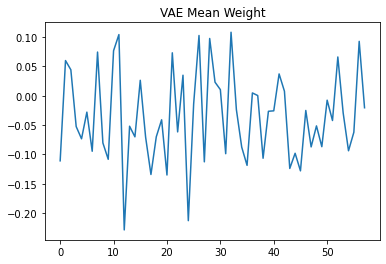

In [99]:
# VAE Latent Space plot 
plt.title('VAE Mean Weight')
plt.plot(encoder.FC_var.weight[27].cpu().detach().numpy(), label="weight")

In [123]:
latent_vector_array = []

with torch.no_grad():
  for batch_idx, (x) in enumerate(tqdm(test_loader)):
    x = x.view(batch_size, x_dim)
    x = x.to(DEVICE)    
    x_hat, mean, log_var, z = model(x)

    # Each batch has 100 latent vecs of size 28
    for batchItem in z:
      # Add to overall latent vector array
      latent_vector_array += [batchItem.cpu().detach().numpy()]

100%|██████████| 40/40 [00:00<00:00, 56.96it/s]


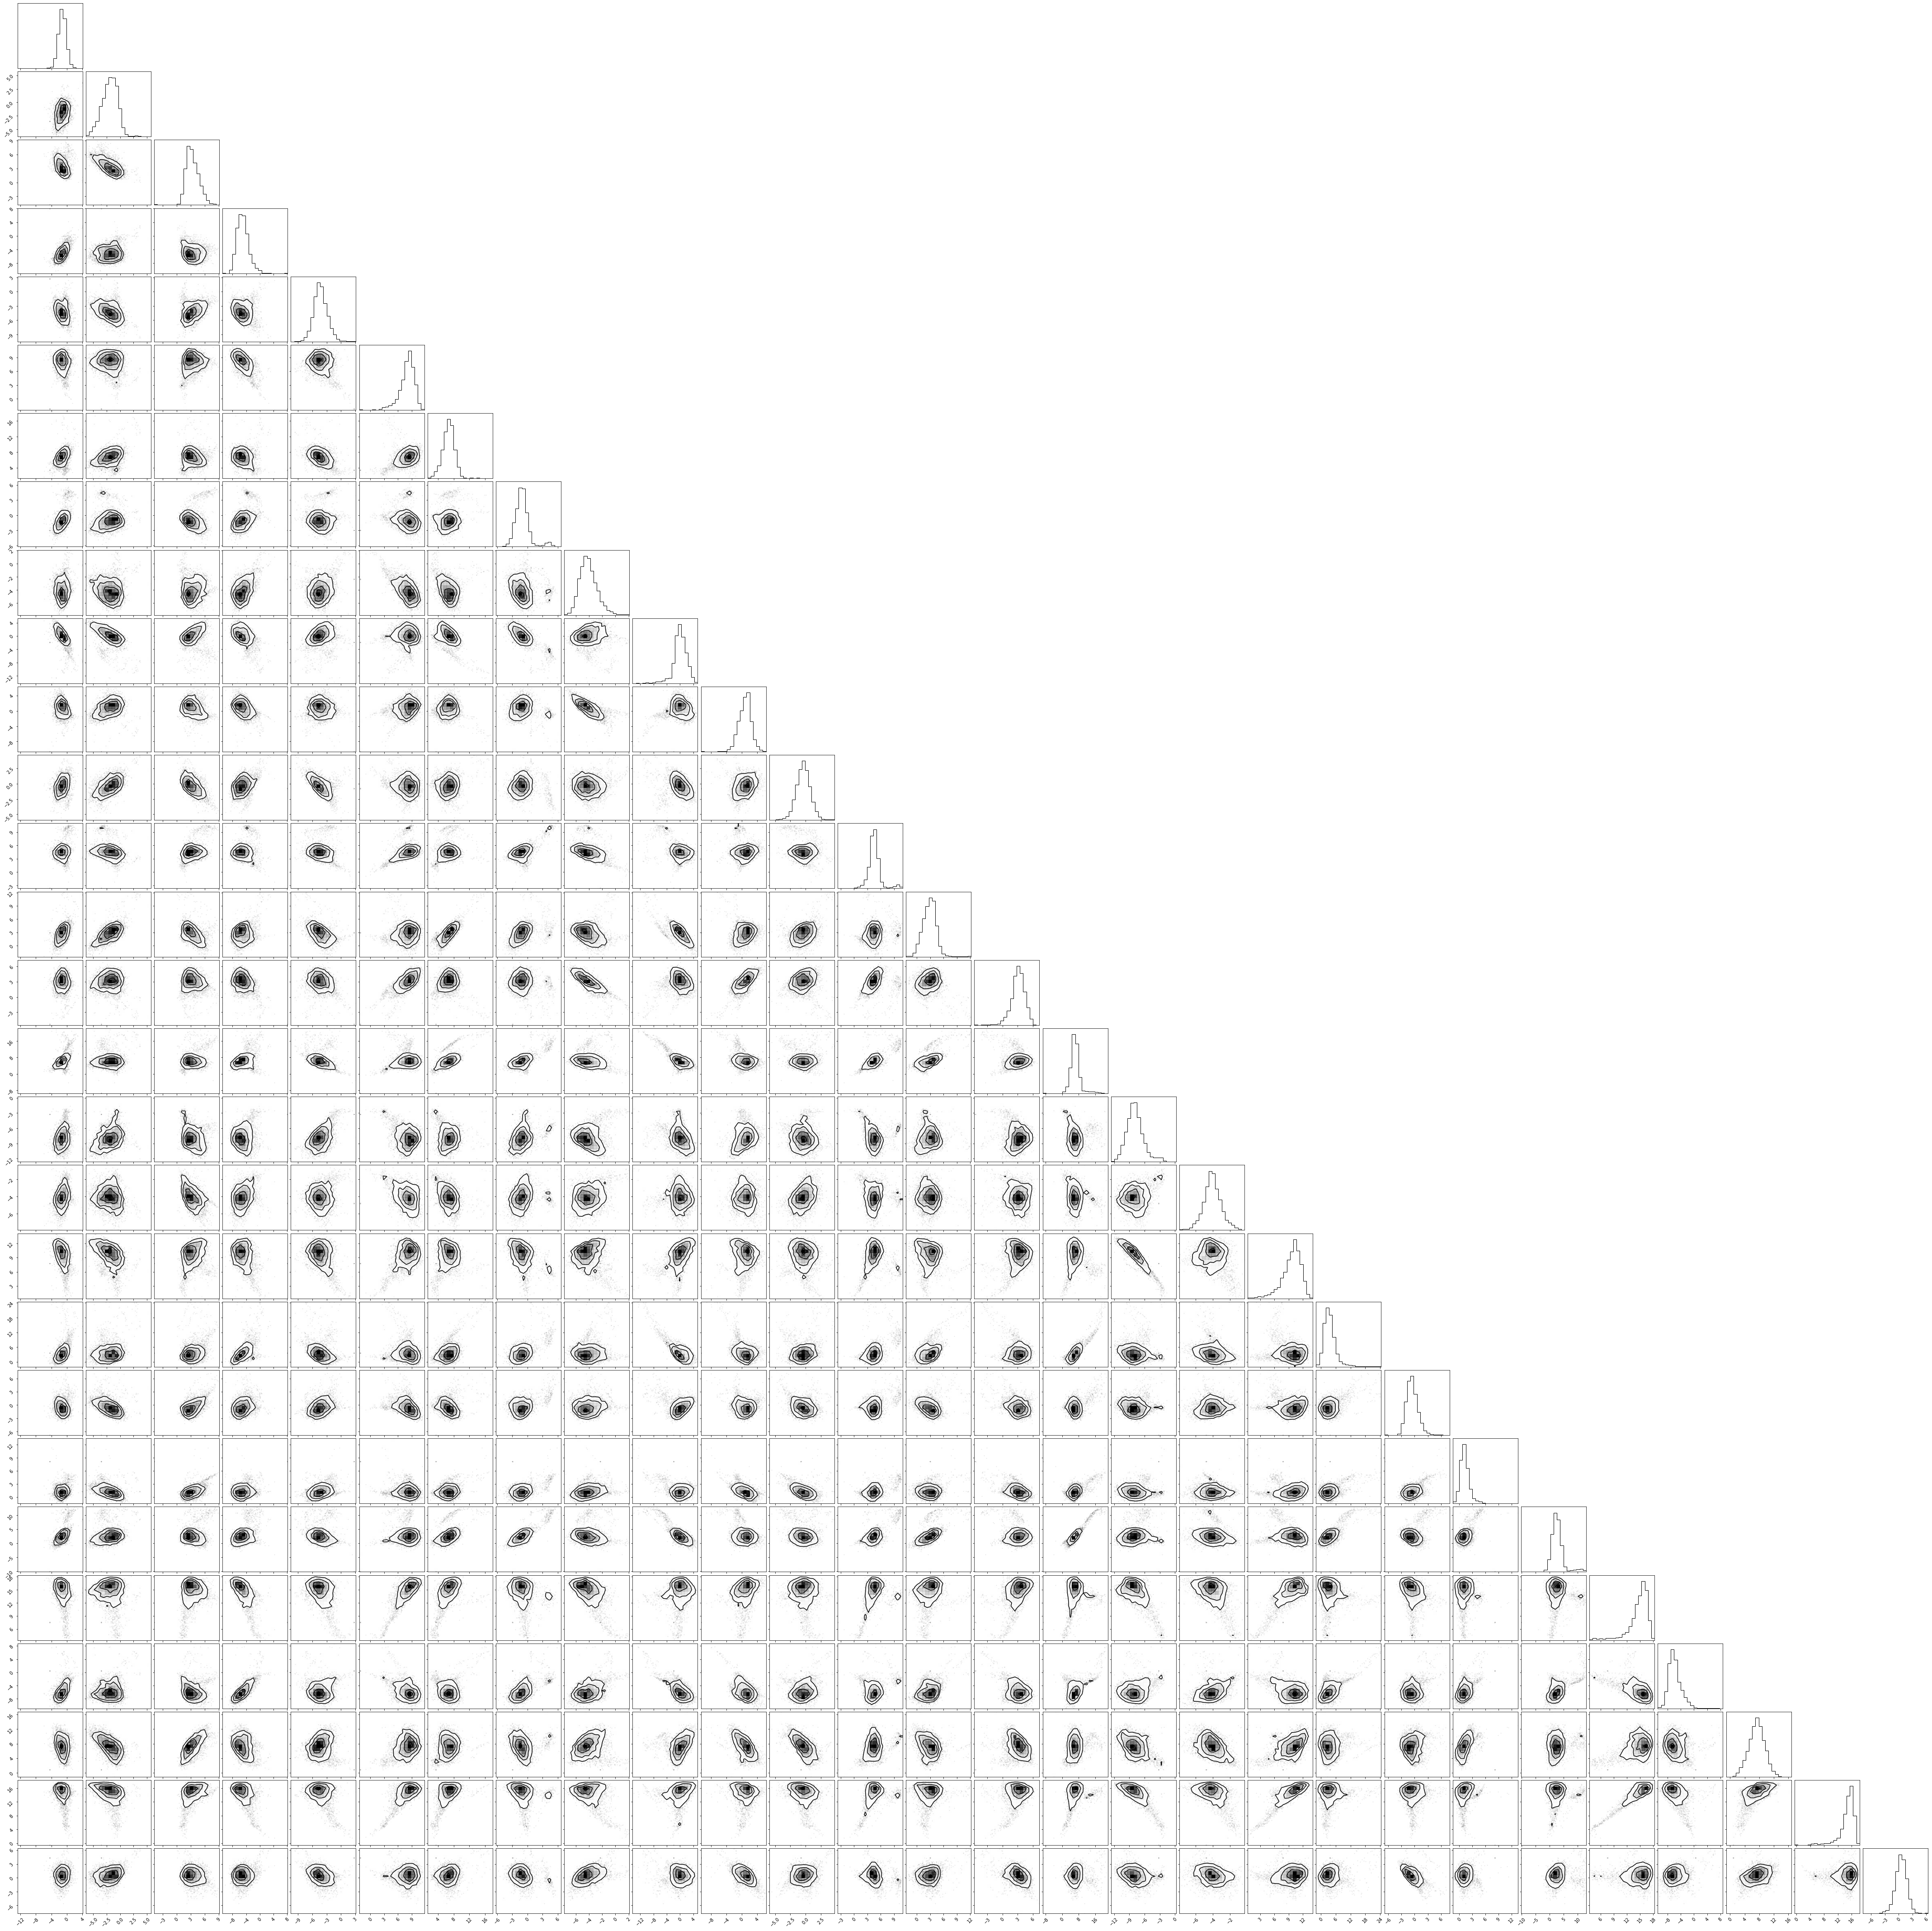

In [131]:
import corner
figure = corner.corner(np.array(latent_vector_array))